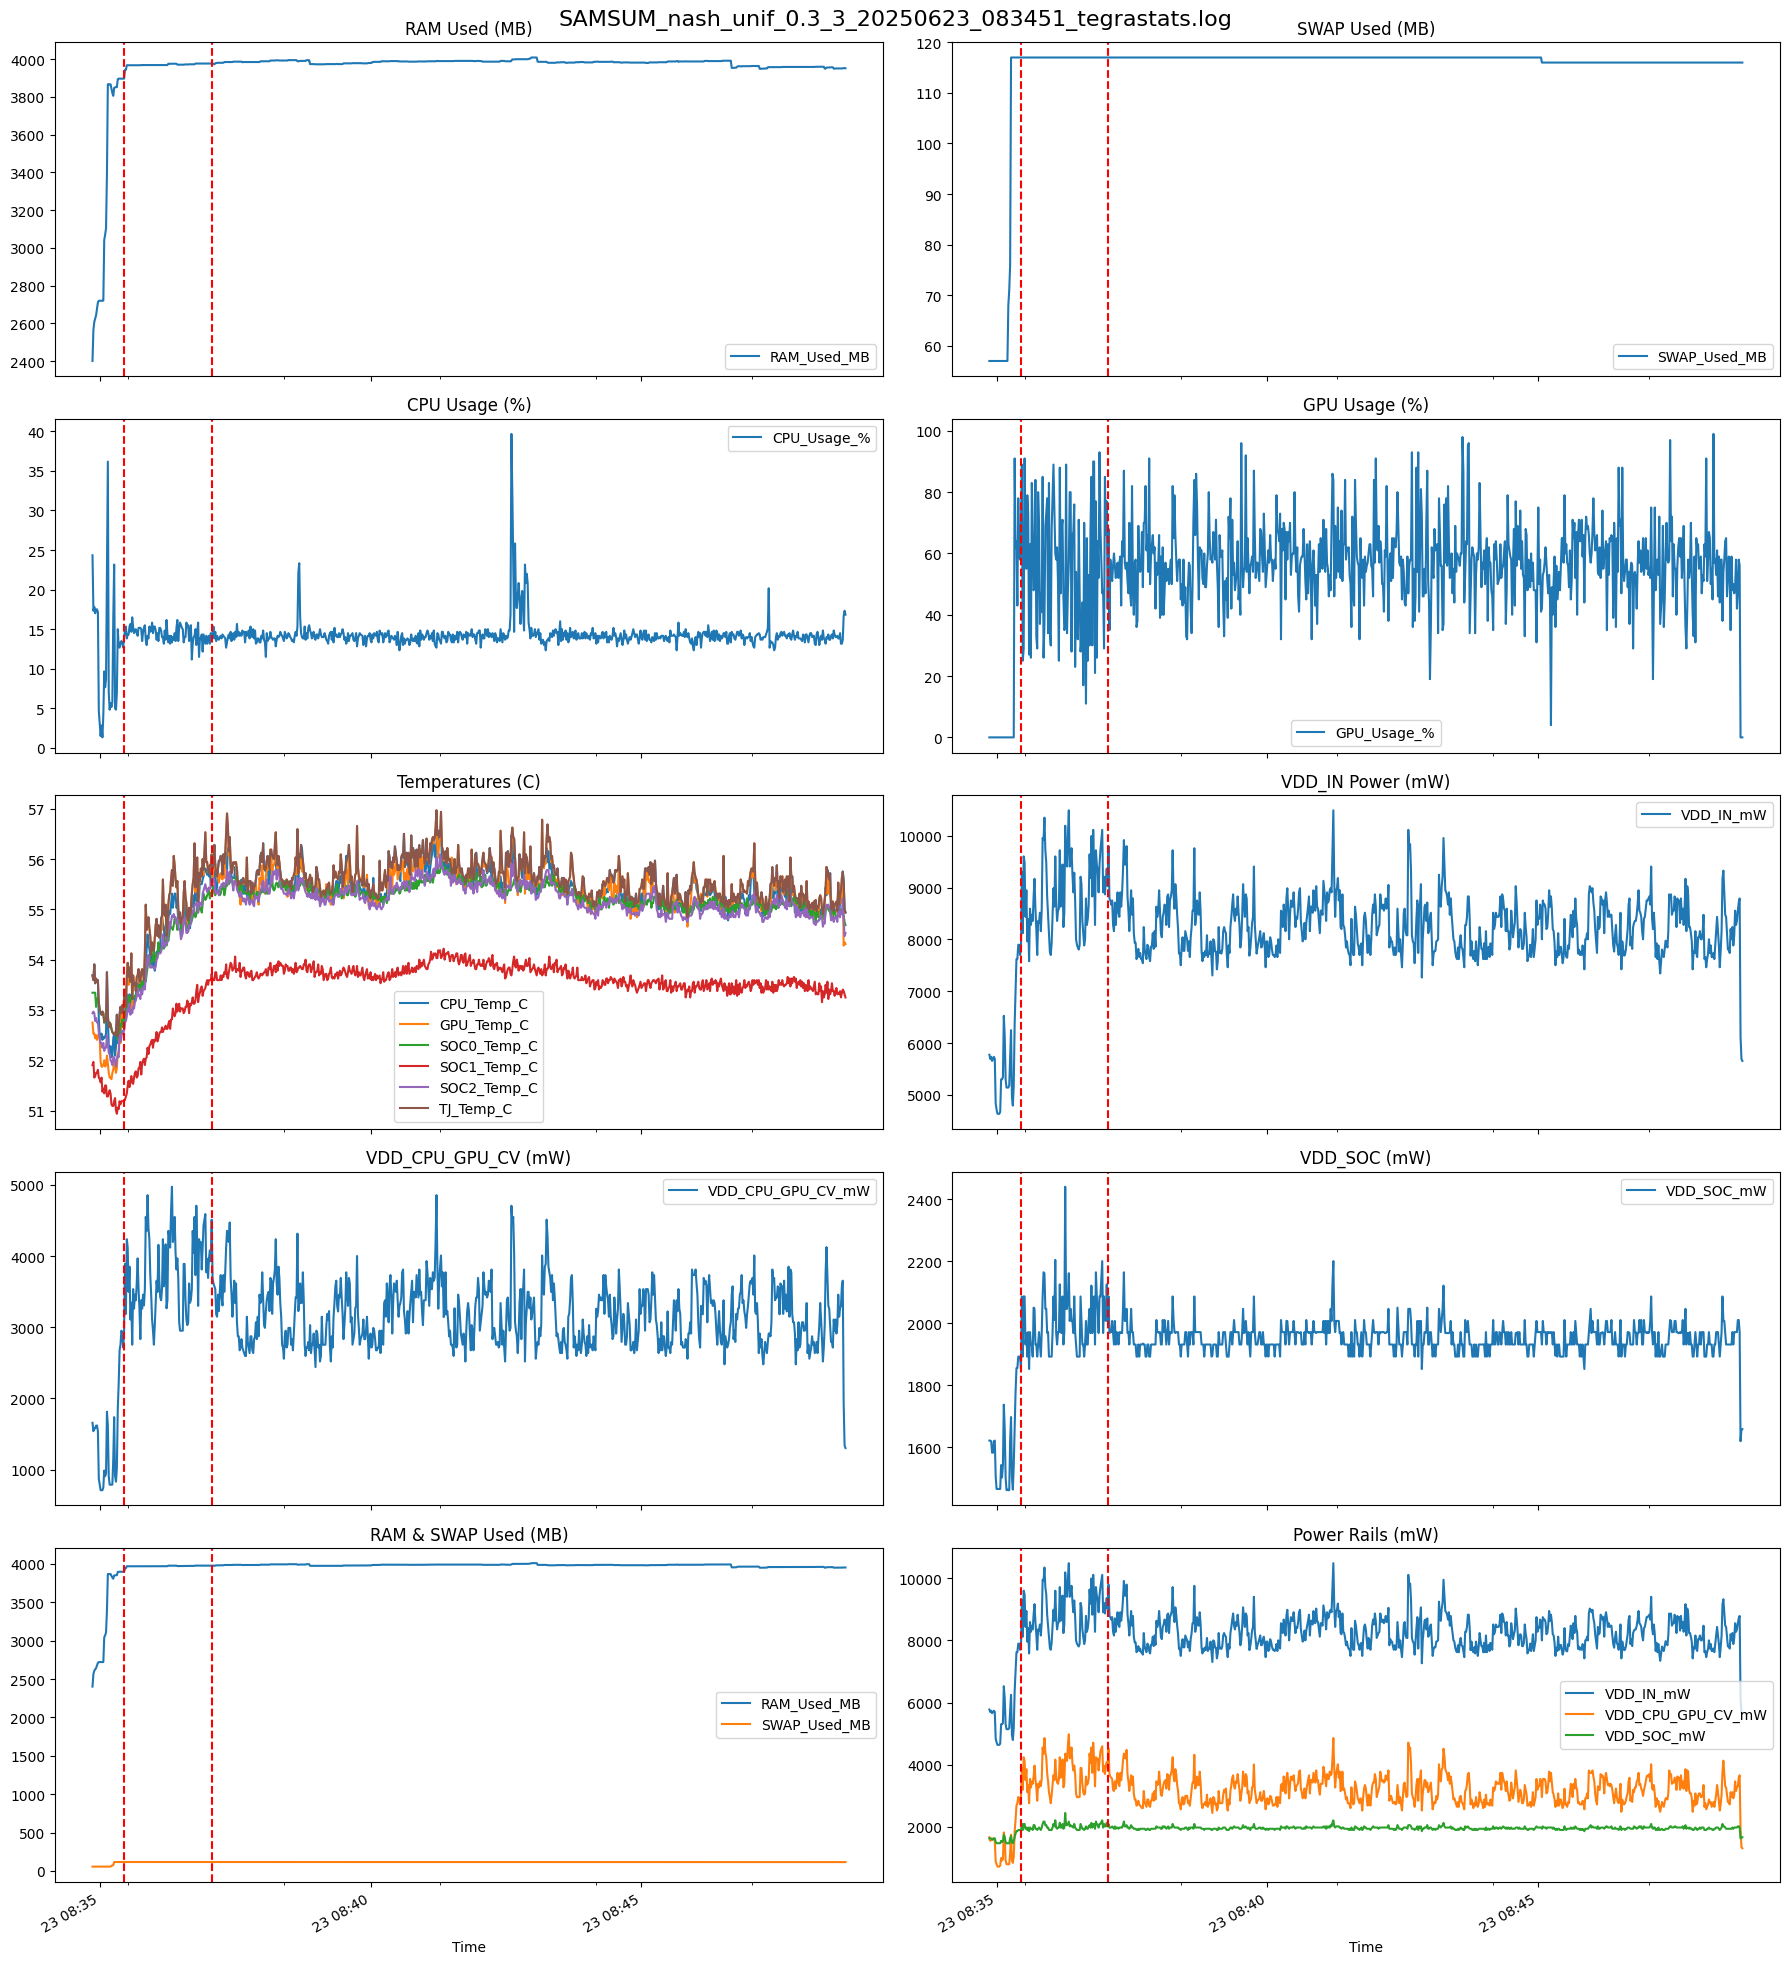

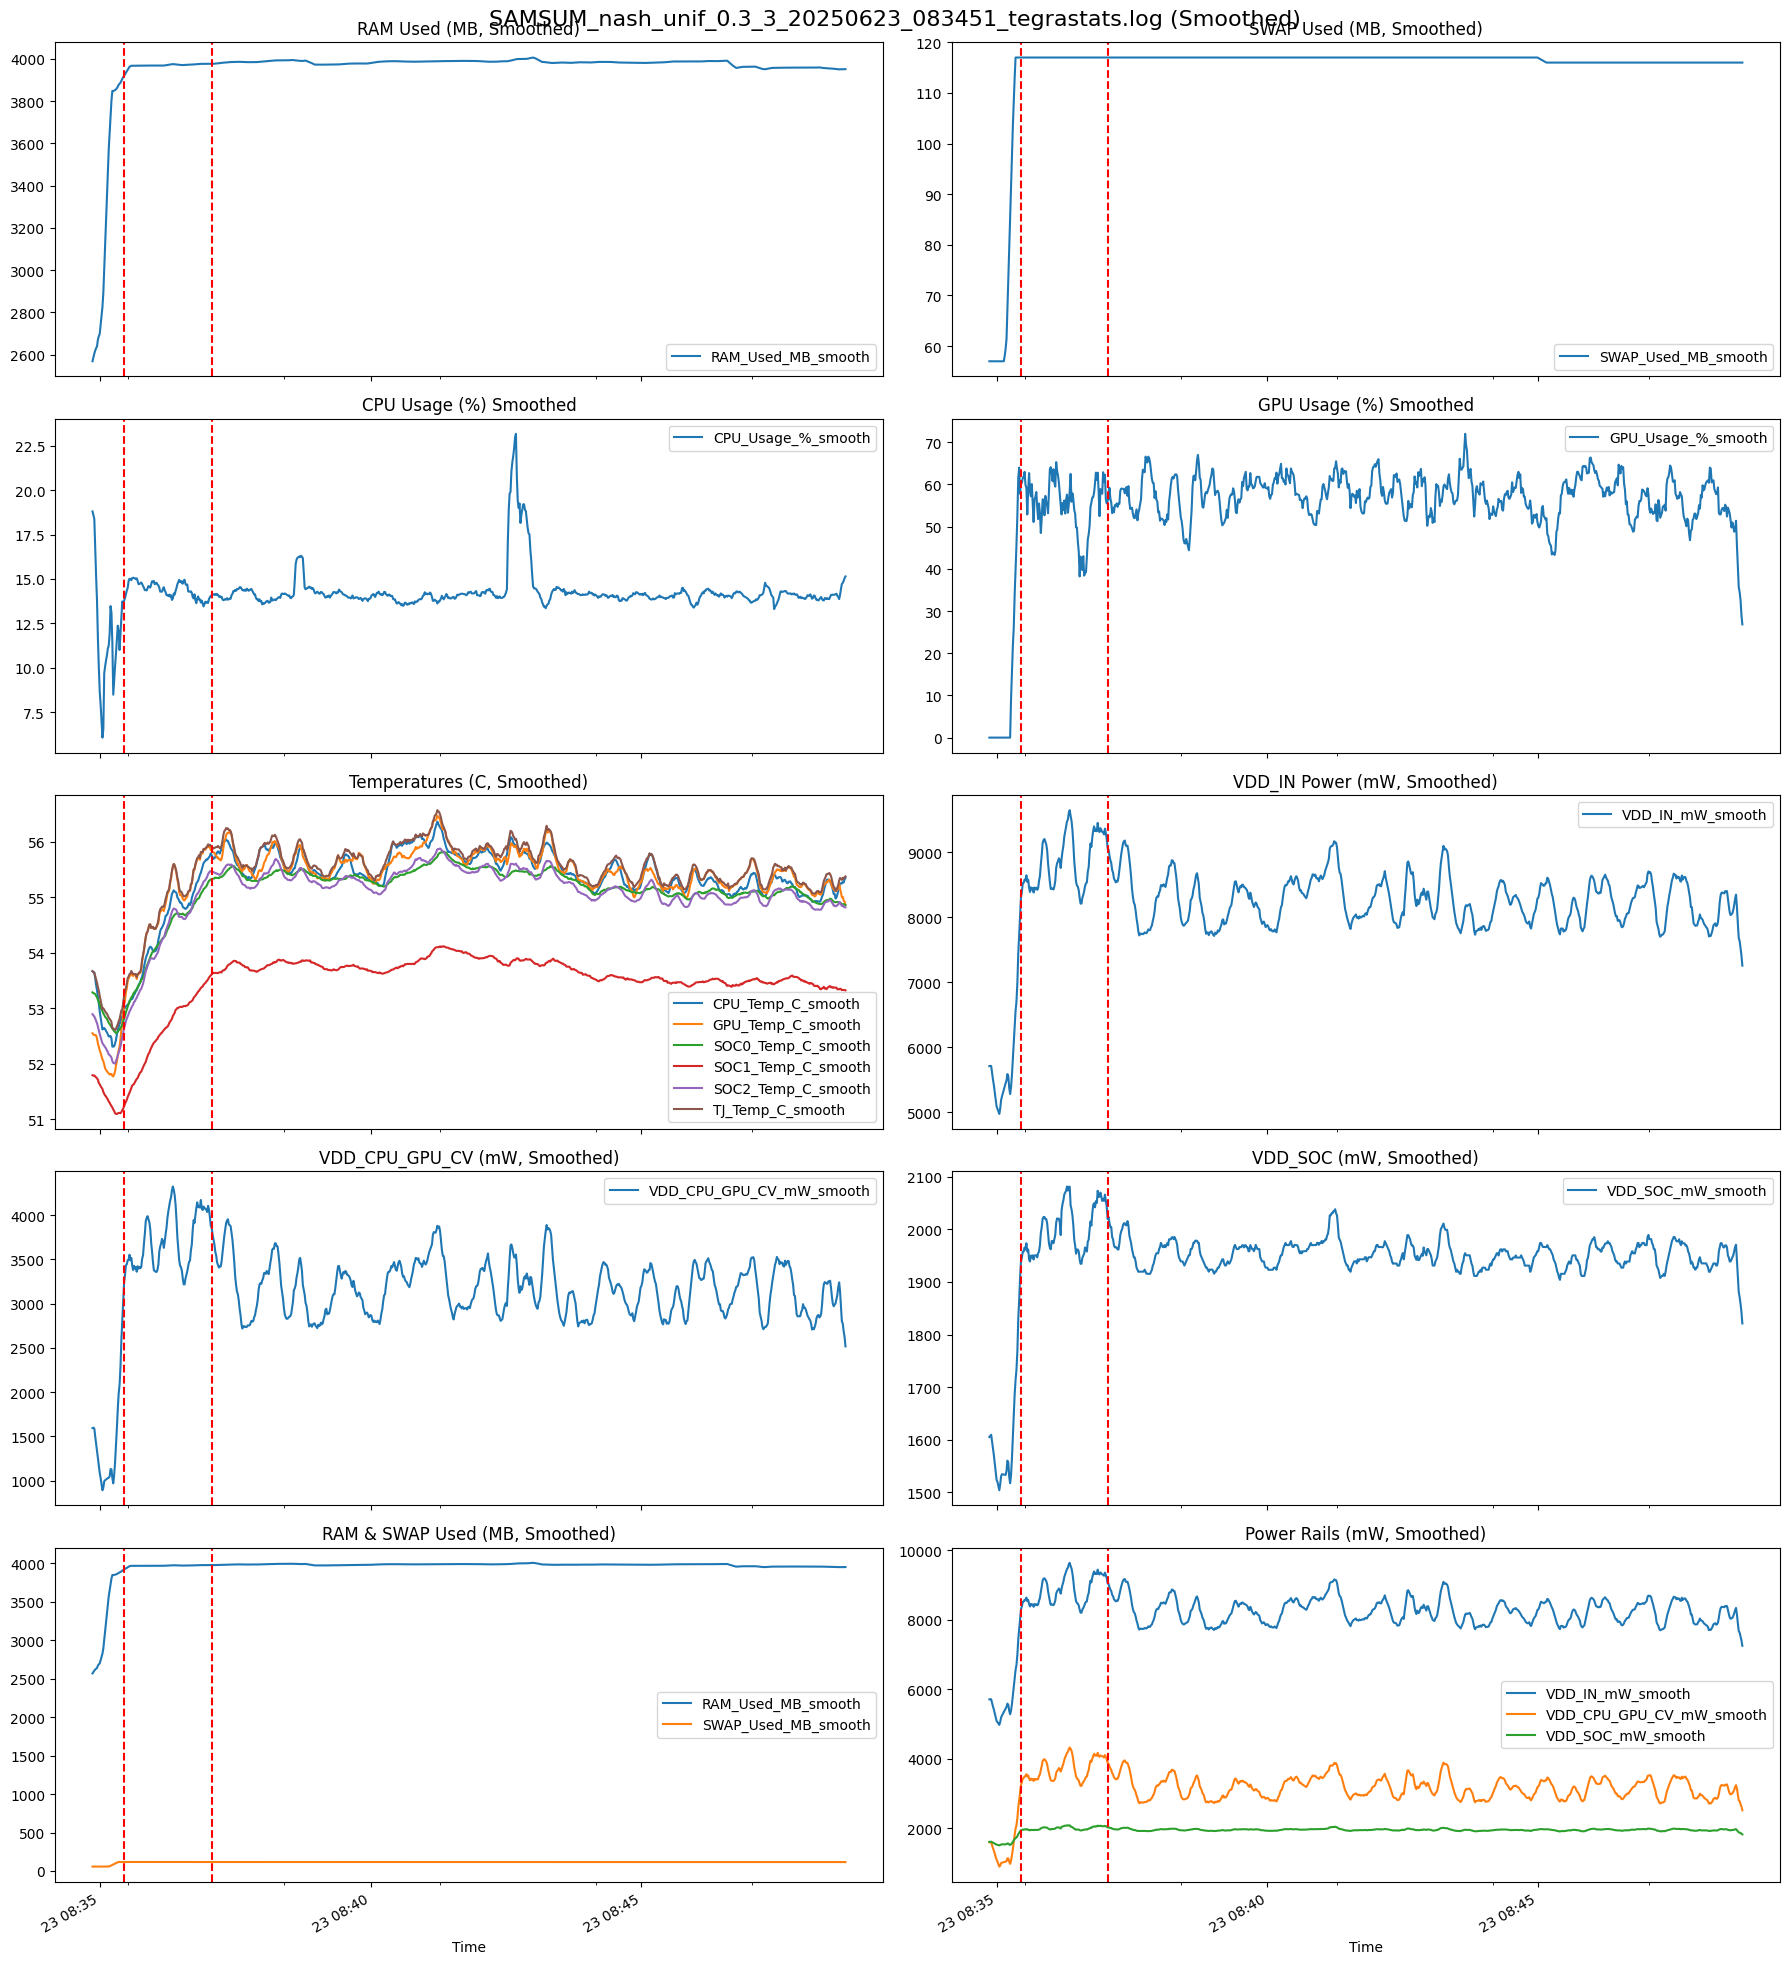

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

logfile = "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.3_3_20250623_083451_tegrastats.log"
logfile_name = os.path.basename(logfile)

timestamps, ram_used, ram_total, swap_used, swap_total, cpu_avg, gr3d_freq = [], [], [], [], [], [], []
cpu_temp, gpu_temp, soc0_temp, soc1_temp, soc2_temp, tj_temp = [], [], [], [], [], []
vdd_in, vdd_cpu_gpu_cv, vdd_soc = [], [], []

with open(logfile) as f:
    for line in f:
        # Timestamp
        ts = line[:19]
        timestamps.append(ts)
        # RAM used/total
        m = re.search(r'RAM (\d+)/(\d+)MB', line)
        ram_used.append(int(m.group(1)) if m else None)
        ram_total.append(int(m.group(2)) if m else None)
        # SWAP used/total
        m = re.search(r'SWAP (\d+)/(\d+)MB', line)
        swap_used.append(int(m.group(1)) if m else None)
        swap_total.append(int(m.group(2)) if m else None)
        # CPU average usage
        m = re.findall(r'CPU \[([^\]]+)\]', line)
        if m:
            cpu_vals = [int(x.split('%')[0]) for x in m[0].split(',')]
            cpu_avg.append(sum(cpu_vals)/len(cpu_vals))
        else:
            cpu_avg.append(None)
        # GPU freq
        m = re.search(r'GR3D_FREQ (\d+)%', line)
        gr3d_freq.append(int(m.group(1)) if m else None)
        # Temperatures
        m = re.search(r'cpu@([\d\.]+)C', line)
        cpu_temp.append(float(m.group(1)) if m else None)
        m = re.search(r'gpu@([\d\.]+)C', line)
        gpu_temp.append(float(m.group(1)) if m else None)
        m = re.search(r'soc0@([\d\.]+)C', line)
        soc0_temp.append(float(m.group(1)) if m else None)
        m = re.search(r'soc1@([\d\.]+)C', line)
        soc1_temp.append(float(m.group(1)) if m else None)
        m = re.search(r'soc2@([\d\.]+)C', line)
        soc2_temp.append(float(m.group(1)) if m else None)
        m = re.search(r'tj@([\d\.]+)C', line)
        tj_temp.append(float(m.group(1)) if m else None)
        # Power
        m = re.search(r'VDD_IN (\d+)mW', line)
        vdd_in.append(int(m.group(1)) if m else None)
        m = re.search(r'VDD_CPU_GPU_CV (\d+)mW', line)
        vdd_cpu_gpu_cv.append(int(m.group(1)) if m else None)
        m = re.search(r'VDD_SOC (\d+)mW', line)
        vdd_soc.append(int(m.group(1)) if m else None)

df = pd.DataFrame({
    "Time": pd.to_datetime(timestamps),
    "RAM_Used_MB": ram_used,
    "RAM_Total_MB": ram_total,
    "SWAP_Used_MB": swap_used,
    "SWAP_Total_MB": swap_total,
    "CPU_Usage_%": cpu_avg,
    "GPU_Usage_%": gr3d_freq,
    "CPU_Temp_C": cpu_temp,
    "GPU_Temp_C": gpu_temp,
    "SOC0_Temp_C": soc0_temp,
    "SOC1_Temp_C": soc1_temp,
    "SOC2_Temp_C": soc2_temp,
    "TJ_Temp_C": tj_temp,
    "VDD_IN_mW": vdd_in,
    "VDD_CPU_GPU_CV_mW": vdd_cpu_gpu_cv,
    "VDD_SOC_mW": vdd_soc
})

# Example: specify your 3 datetime strings here (replace with your actual datetimes)
vline_times = [
    "2025-06-23 08:35:27.038616",
    "2025-06-23 08:37:03.946562"
]
vline_times = [pd.to_datetime(t) for t in vline_times]

fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
fig.suptitle(f"{logfile_name}", fontsize=16)
df.plot(x="Time", y="RAM_Used_MB", ax=axs[0,0], title="RAM Used (MB)")
df.plot(x="Time", y="SWAP_Used_MB", ax=axs[0,1], title="SWAP Used (MB)")
df.plot(x="Time", y="CPU_Usage_%", ax=axs[1,0], title="CPU Usage (%)")
df.plot(x="Time", y="GPU_Usage_%", ax=axs[1,1], title="GPU Usage (%)")
df.plot(x="Time", y=["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"], ax=axs[2,0], title="Temperatures (C)")
df.plot(x="Time", y="VDD_IN_mW", ax=axs[2,1], title="VDD_IN Power (mW)")
df.plot(x="Time", y="VDD_CPU_GPU_CV_mW", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW)")
df.plot(x="Time", y="VDD_SOC_mW", ax=axs[3,1], title="VDD_SOC (mW)")
df.plot(x="Time", y=["RAM_Used_MB", "SWAP_Used_MB"], ax=axs[4,0], title="RAM & SWAP Used (MB)")
df.plot(x="Time", y=["VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"], ax=axs[4,1], title="Power Rails (mW)")

# Add vertical lines to all subplots
for ax_row in axs:
    for ax in ax_row:
        for vline in vline_times:
            ax.axvline(vline, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Smooth selected columns using a moving average
smooth_cols = [
    "RAM_Used_MB", "SWAP_Used_MB", "CPU_Usage_%", "GPU_Usage_%",
    "CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C",
    "VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"
]
window = 10  # Adjust window size as needed

for col in smooth_cols:
    df[f"{col}_smooth"] = df[col].rolling(window=window, min_periods=1, center=True).mean()

fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
fig.suptitle(f"{logfile_name} (Smoothed)", fontsize=16)
df.plot(x="Time", y="RAM_Used_MB_smooth", ax=axs[0,0], title="RAM Used (MB, Smoothed)")
df.plot(x="Time", y="SWAP_Used_MB_smooth", ax=axs[0,1], title="SWAP Used (MB, Smoothed)")
df.plot(x="Time", y="CPU_Usage_%_smooth", ax=axs[1,0], title="CPU Usage (%) Smoothed")
df.plot(x="Time", y="GPU_Usage_%_smooth", ax=axs[1,1], title="GPU Usage (%) Smoothed")
df.plot(
    x="Time",
    y=[f"{c}_smooth" for c in ["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"]],
    ax=axs[2,0], title="Temperatures (C, Smoothed)"
)
df.plot(x="Time", y="VDD_IN_mW_smooth", ax=axs[2,1], title="VDD_IN Power (mW, Smoothed)")
df.plot(x="Time", y="VDD_CPU_GPU_CV_mW_smooth", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW, Smoothed)")
df.plot(x="Time", y="VDD_SOC_mW_smooth", ax=axs[3,1], title="VDD_SOC (mW, Smoothed)")
df.plot(x="Time", y=["RAM_Used_MB_smooth", "SWAP_Used_MB_smooth"], ax=axs[4,0], title="RAM & SWAP Used (MB, Smoothed)")
df.plot(
    x="Time",
    y=["VDD_IN_mW_smooth", "VDD_CPU_GPU_CV_mW_smooth", "VDD_SOC_mW_smooth"],
    ax=axs[4,1], title="Power Rails (mW, Smoothed)"
)

# Add vertical lines to all smoothed subplots
for ax_row in axs:
    for ax in ax_row:
        for vline in vline_times:
            ax.axvline(vline, color='red', linestyle='--')

plt.tight_layout()
plt.show()

/tmp/ipykernel_208123/1614304627.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_208123/1614304627.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_208123/1614304627.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_208123/1614304627.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


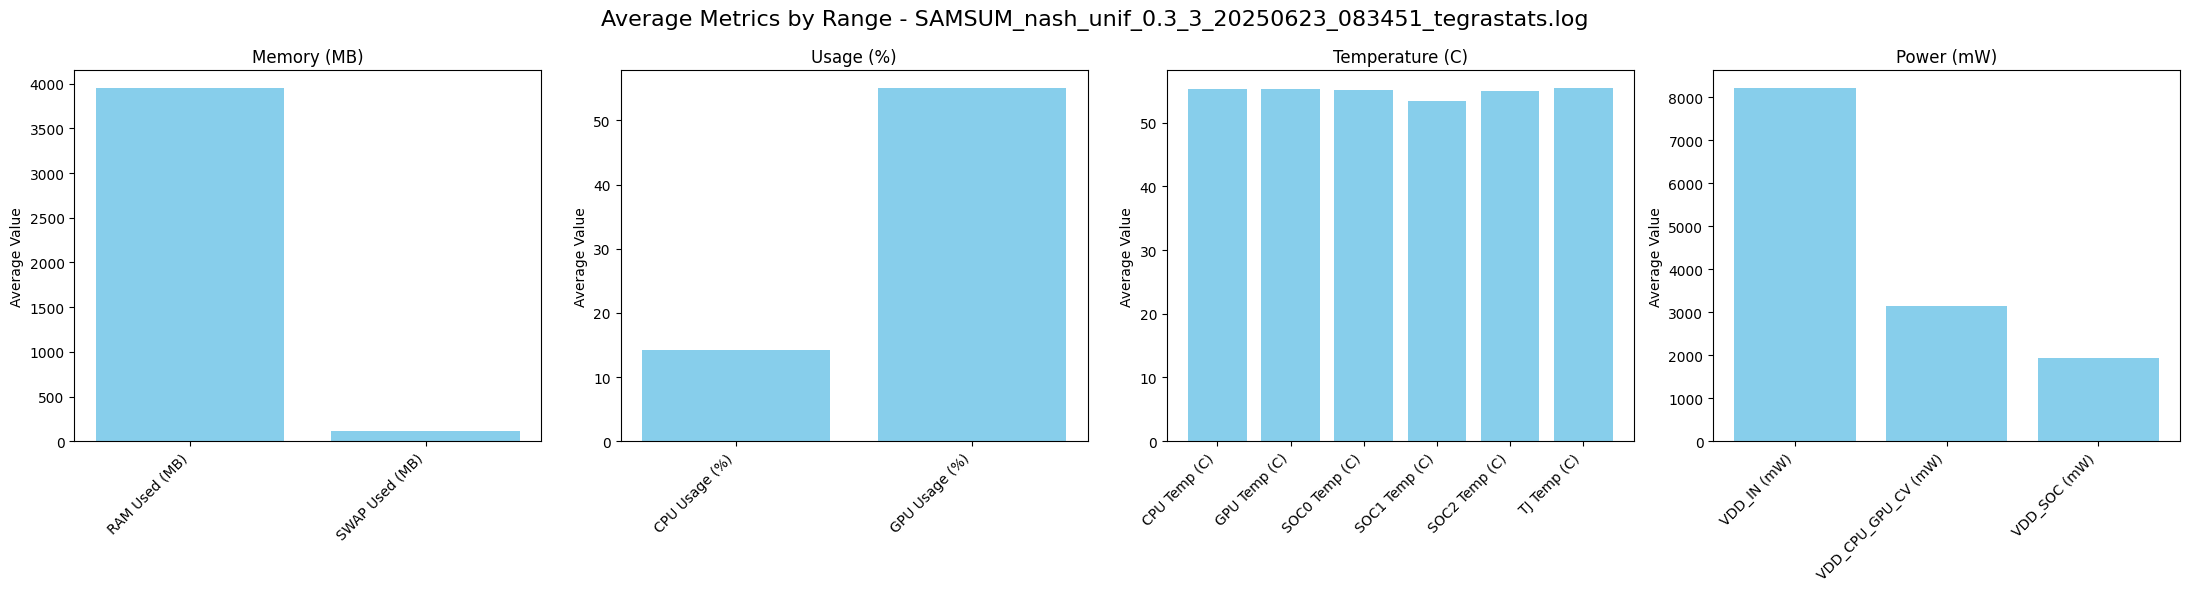

In [5]:
# --- New Cell ---
# Bar graph for average values of the metrics, separated by value range

# Group metrics by their value ranges for clearer visualization
metrics_groups = {
    "Memory (MB)": [
        ("RAM Used (MB)", df["RAM_Used_MB"].mean()),
        ("SWAP Used (MB)", df["SWAP_Used_MB"].mean()),
    ],
    "Usage (%)": [
        ("CPU Usage (%)", df["CPU_Usage_%"].mean()),
        ("GPU Usage (%)", df["GPU_Usage_%"].mean()),
    ],
    "Temperature (C)": [
        ("CPU Temp (C)", df["CPU_Temp_C"].mean()),
        ("GPU Temp (C)", df["GPU_Temp_C"].mean()),
        ("SOC0 Temp (C)", df["SOC0_Temp_C"].mean()),
        ("SOC1 Temp (C)", df["SOC1_Temp_C"].mean()),
        ("SOC2 Temp (C)", df["SOC2_Temp_C"].mean()),
        ("TJ Temp (C)", df["TJ_Temp_C"].mean()),
    ],
    "Power (mW)": [
        ("VDD_IN (mW)", df["VDD_IN_mW"].mean()),
        ("VDD_CPU_GPU_CV (mW)", df["VDD_CPU_GPU_CV_mW"].mean()),
        ("VDD_SOC (mW)", df["VDD_SOC_mW"].mean()),
    ]
}

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
for ax, (group, items) in zip(axs, metrics_groups.items()):
    labels, values = zip(*items)
    ax.bar(labels, values, color='skyblue')
    ax.set_title(group)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Average Value')

fig.suptitle(f'Average Metrics by Range - {logfile_name}', fontsize=16)
plt.tight_layout()
plt.show()